In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [0]:
from fastai.text import *
from fastai.imports import *
from fastai.text import *
from fastai import *
from fastai.callbacks import *

In [5]:
path = Path('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification')
path.ls()

[PosixPath('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification/train.csv'),
 PosixPath('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification/sample_sub.csv'),
 PosixPath('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification/test.csv'),
 PosixPath('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification/updated_test.csv'),
 PosixPath('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification/updated_ss.csv'),
 PosixPath('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification/updated_train.csv')]

In [0]:
train = pd.read_csv('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification/updated_train.csv')
test = pd.read_csv('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification/updated_test.csv')
sub = pd.read_csv('/content/gdrive/My Drive/Competitions/COVID-19 Tweet Classification/updated_ss.csv')

In [0]:
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [8]:
train.shape, test.shape, sub.shape

((5287, 2), (1962, 1), (1962, 2))

In [9]:
train.head(2)

,text,target
0,The bitcoin halving is cancelled due to,1
1,MercyOfAllah In good times wrapped in its gran...,0


In [10]:
test.head(2)

,text
0,Why is explained in the video take a look
1,Ed Davey fasting for Ramadan No contest


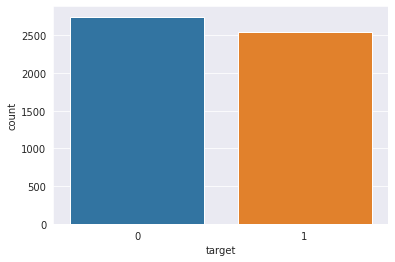

In [11]:
sns.countplot(x='target', data=train)

In [0]:
def random_seed(seed_value):
    import random 
    random.seed(seed_value)  
    import numpy as np
    np.random.seed(seed_value)  
    import torch
    torch.manual_seed(seed_value)  
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True   
        torch.backends.cudnn.benchmark = False

In [35]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

y_pred_totcb = []
y_pred_valid = []

fold = KFold(n_splits=5, shuffle=True, random_state=0)
i=1

for train_index, test_index in fold.split(train):
    
    train_df = train.iloc[train_index]
    valid_df = train.iloc[test_index]

    random_seed(1)
    
    data_lm = TextLMDataBunch.from_df(Path(path), train_df, valid_df, test, text_cols=[0], bs=32)
    data_clas = TextClasDataBunch.from_df(Path(path), train_df, valid_df, test, text_cols=[0], label_cols=1, bs=32)
    
    learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7, model_dir='/tmp/model/')
    learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7), callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss')])
    learn.unfreeze()
    learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss')])
    learn.save_encoder('model_enc')
    
    learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7, model_dir='/tmp/model/')
    learn.load_encoder('model_enc')
    learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7), callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss')])
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss')])
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss')])
    learn.unfreeze()
    learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss')])
   
    log_preds, valid_labels = learn.get_preds(ds_type=DatasetType.Valid, ordered=True)
    y_pred_valid.append(log_loss(valid_df['target'], log_preds))

    log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test, ordered=True)
    y_pred_totcb.append(np.array(log_preds)[:,1])
    print(f'fold {i} completed')
    i = i+1

epoch,train_loss,valid_loss,accuracy,time
0,5.172569,4.471956,0.243006,00:03


Better model found at epoch 0 with valid_loss value: 4.4719557762146.


epoch,train_loss,valid_loss,accuracy,time
0,4.581429,4.281609,0.264025,00:04
1,4.406153,4.198696,0.272768,00:04
2,4.165944,4.144849,0.279539,00:04
3,3.894328,4.152259,0.279762,00:04
4,3.700828,4.161661,0.280320,00:04


Better model found at epoch 0 with valid_loss value: 4.281609058380127.
Better model found at epoch 1 with valid_loss value: 4.198695659637451.
Better model found at epoch 2 with valid_loss value: 4.1448493003845215.


epoch,train_loss,valid_loss,accuracy,time
0,0.436754,0.342274,0.853497,00:02


Better model found at epoch 0 with valid_loss value: 0.3422740697860718.


epoch,train_loss,valid_loss,accuracy,time
0,0.430142,0.322554,0.867675,00:03


Better model found at epoch 0 with valid_loss value: 0.3225541412830353.


epoch,train_loss,valid_loss,accuracy,time
0,0.360256,0.269577,0.889414,00:04


Better model found at epoch 0 with valid_loss value: 0.2695774435997009.


epoch,train_loss,valid_loss,accuracy,time
0,0.303346,0.262631,0.891304,00:06
1,0.287273,0.245521,0.901701,00:05
2,0.290227,0.228615,0.913989,00:05
3,0.251820,0.221564,0.914934,00:05
4,0.231656,0.223181,0.902646,00:06
5,0.204356,0.221653,0.902646,00:06
6,0.212624,0.214525,0.908318,00:05
7,0.182002,0.217520,0.904537,00:06
8,0.158102,0.220426,0.915879,00:05
9,0.156773,0.216343,0.912098,00:05


Better model found at epoch 0 with valid_loss value: 0.2626314163208008.
Better model found at epoch 1 with valid_loss value: 0.2455209195613861.
Better model found at epoch 2 with valid_loss value: 0.22861462831497192.
Better model found at epoch 3 with valid_loss value: 0.2215636819601059.
Better model found at epoch 6 with valid_loss value: 0.2145254909992218.


fold 1 completed


epoch,train_loss,valid_loss,accuracy,time
0,5.176798,4.433238,0.250595,00:03


Better model found at epoch 0 with valid_loss value: 4.433237552642822.


epoch,train_loss,valid_loss,accuracy,time
0,4.589734,4.251070,0.271801,00:04
1,4.414340,4.159570,0.278497,00:04
2,4.174242,4.122769,0.283073,00:04
3,3.895806,4.117897,0.286570,00:04
4,3.703576,4.132845,0.282850,00:04


Better model found at epoch 0 with valid_loss value: 4.251070499420166.
Better model found at epoch 1 with valid_loss value: 4.159570217132568.
Better model found at epoch 2 with valid_loss value: 4.122768878936768.
Better model found at epoch 3 with valid_loss value: 4.117897033691406.


epoch,train_loss,valid_loss,accuracy,time
0,0.447631,0.334629,0.867675,00:02


Better model found at epoch 0 with valid_loss value: 0.3346286118030548.


epoch,train_loss,valid_loss,accuracy,time
0,0.415836,0.316537,0.879962,00:03


Better model found at epoch 0 with valid_loss value: 0.31653669476509094.


epoch,train_loss,valid_loss,accuracy,time
0,0.351846,0.255117,0.894140,00:04


Better model found at epoch 0 with valid_loss value: 0.25511690974235535.


epoch,train_loss,valid_loss,accuracy,time
0,0.297500,0.248058,0.896975,00:06
1,0.284175,0.235281,0.901701,00:05
2,0.267500,0.227334,0.901701,00:05
3,0.244544,0.226811,0.897921,00:05
4,0.223684,0.227046,0.898866,00:06
5,0.193597,0.229367,0.900756,00:06
6,0.188415,0.228495,0.902646,00:05
7,0.156669,0.234188,0.906427,00:06
8,0.148899,0.223255,0.904537,00:05
9,0.157293,0.224065,0.907372,00:06


Better model found at epoch 0 with valid_loss value: 0.24805834889411926.
Better model found at epoch 1 with valid_loss value: 0.23528118431568146.
Better model found at epoch 2 with valid_loss value: 0.22733357548713684.
Better model found at epoch 3 with valid_loss value: 0.22681085765361786.
Better model found at epoch 8 with valid_loss value: 0.22325502336025238.


fold 2 completed


epoch,train_loss,valid_loss,accuracy,time
0,5.167578,4.466823,0.245639,00:03


Better model found at epoch 0 with valid_loss value: 4.466822624206543.


epoch,train_loss,valid_loss,accuracy,time
0,4.576016,4.291261,0.266964,00:04
1,4.403887,4.189648,0.276820,00:04
2,4.163608,4.154905,0.281387,00:04
3,3.887048,4.150278,0.280735,00:04
4,3.692322,4.162870,0.281216,00:04


Better model found at epoch 0 with valid_loss value: 4.291260719299316.
Better model found at epoch 1 with valid_loss value: 4.189647674560547.
Better model found at epoch 2 with valid_loss value: 4.154904842376709.
Better model found at epoch 3 with valid_loss value: 4.150277614593506.


epoch,train_loss,valid_loss,accuracy,time
0,0.469801,0.329351,0.860927,00:02


Better model found at epoch 0 with valid_loss value: 0.32935085892677307.


epoch,train_loss,valid_loss,accuracy,time
0,0.420243,0.310207,0.869442,00:03


Better model found at epoch 0 with valid_loss value: 0.310207337141037.


epoch,train_loss,valid_loss,accuracy,time
0,0.354193,0.262495,0.899716,00:04


Better model found at epoch 0 with valid_loss value: 0.26249539852142334.


epoch,train_loss,valid_loss,accuracy,time
0,0.307259,0.247206,0.894986,00:05
1,0.295824,0.234364,0.901608,00:05
2,0.257939,0.227079,0.907285,00:05
3,0.244361,0.224618,0.909177,00:05
4,0.231395,0.223973,0.909177,00:06
5,0.204691,0.229413,0.912961,00:05
6,0.173049,0.235475,0.911069,00:05
7,0.169473,0.233815,0.917692,00:06
8,0.158463,0.233963,0.916745,00:06
9,0.146998,0.233773,0.911069,00:05


Better model found at epoch 0 with valid_loss value: 0.2472056895494461.
Better model found at epoch 1 with valid_loss value: 0.23436406254768372.
Better model found at epoch 2 with valid_loss value: 0.22707892954349518.
Better model found at epoch 3 with valid_loss value: 0.22461842000484467.
Better model found at epoch 4 with valid_loss value: 0.22397267818450928.


fold 3 completed


epoch,train_loss,valid_loss,accuracy,time
0,5.176648,4.460651,0.250818,00:03


Better model found at epoch 0 with valid_loss value: 4.46065092086792.


epoch,train_loss,valid_loss,accuracy,time
0,4.583306,4.262858,0.274070,00:04
1,4.402832,4.188409,0.279241,00:04
2,4.161474,4.155222,0.279948,00:04
3,3.887435,4.152390,0.282106,00:04
4,3.696142,4.162538,0.282217,00:04


Better model found at epoch 0 with valid_loss value: 4.2628583908081055.
Better model found at epoch 1 with valid_loss value: 4.188409328460693.
Better model found at epoch 2 with valid_loss value: 4.155221939086914.
Better model found at epoch 3 with valid_loss value: 4.152390003204346.


epoch,train_loss,valid_loss,accuracy,time
0,0.460928,0.352497,0.855251,00:02


Better model found at epoch 0 with valid_loss value: 0.3524971306324005.


epoch,train_loss,valid_loss,accuracy,time
0,0.419549,0.330355,0.856197,00:03


Better model found at epoch 0 with valid_loss value: 0.3303546905517578.


epoch,train_loss,valid_loss,accuracy,time
0,0.356884,0.285825,0.866604,00:04


Better model found at epoch 0 with valid_loss value: 0.28582528233528137.


epoch,train_loss,valid_loss,accuracy,time
0,0.297723,0.274343,0.893094,00:05
1,0.301350,0.255631,0.896878,00:05
2,0.261265,0.262856,0.887417,00:05
3,0.251228,0.249259,0.896878,00:05
4,0.230505,0.251631,0.893094,00:06
5,0.193380,0.255599,0.891201,00:05
6,0.189246,0.256385,0.885525,00:05
7,0.158161,0.264680,0.889309,00:06
8,0.161774,0.260046,0.886471,00:06
9,0.155173,0.262830,0.887417,00:05


Better model found at epoch 0 with valid_loss value: 0.27434253692626953.
Better model found at epoch 1 with valid_loss value: 0.25563108921051025.
Better model found at epoch 3 with valid_loss value: 0.24925920367240906.


fold 4 completed


epoch,train_loss,valid_loss,accuracy,time
0,5.175083,4.444995,0.248437,00:03


Better model found at epoch 0 with valid_loss value: 4.444995403289795.


epoch,train_loss,valid_loss,accuracy,time
0,4.590492,4.257625,0.269643,00:04
1,4.414230,4.154501,0.281510,00:04
2,4.178919,4.116171,0.283780,00:04
3,3.908820,4.116884,0.284226,00:04
4,3.717366,4.122365,0.284263,00:04


Better model found at epoch 0 with valid_loss value: 4.257625102996826.
Better model found at epoch 1 with valid_loss value: 4.154501438140869.
Better model found at epoch 2 with valid_loss value: 4.116170883178711.


epoch,train_loss,valid_loss,accuracy,time
0,0.465485,0.333285,0.856197,00:02


Better model found at epoch 0 with valid_loss value: 0.33328545093536377.


epoch,train_loss,valid_loss,accuracy,time
0,0.445013,0.307315,0.870388,00:03


Better model found at epoch 0 with valid_loss value: 0.30731531977653503.


epoch,train_loss,valid_loss,accuracy,time
0,0.360287,0.267524,0.883633,00:04


Better model found at epoch 0 with valid_loss value: 0.26752400398254395.


epoch,train_loss,valid_loss,accuracy,time
0,0.276517,0.261846,0.882687,00:05
1,0.302666,0.247912,0.887417,00:05
2,0.261975,0.248648,0.890255,00:05
3,0.235961,0.243096,0.905393,00:05
4,0.230779,0.240035,0.899716,00:06
5,0.207758,0.232356,0.906339,00:05
6,0.169930,0.234031,0.909177,00:05
7,0.171229,0.236877,0.903500,00:06
8,0.163941,0.232342,0.905393,00:06
9,0.167942,0.235460,0.905393,00:05


Better model found at epoch 0 with valid_loss value: 0.26184573769569397.
Better model found at epoch 1 with valid_loss value: 0.2479124516248703.
Better model found at epoch 3 with valid_loss value: 0.2430955171585083.
Better model found at epoch 4 with valid_loss value: 0.24003463983535767.
Better model found at epoch 5 with valid_loss value: 0.23235605657100677.
Better model found at epoch 8 with valid_loss value: 0.232341930270195.


fold 5 completed


In [36]:
np.mean(y_pred_valid)

0.22867086323398617

In [0]:
y_pred = np.mean(y_pred_totcb, 0)

# Submission

In [38]:
sub['target'] = y_pred
sub.head()

,ID,target
0,test_2,0.622622
1,test_3,0.001728
2,test_4,0.018030
3,test_8,0.981860
4,test_9,0.000862


In [39]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,
    filename=filename)
    return HTML(html)

create_download_link(sub)